# EDA on Merged Dataset (Forward Filled!)

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Fixing Datatypes

In [2]:
# Print the datatypes of all columns

merged_df = pd.read_csv('../data/processed/merged_dataset_ffill.csv', sep = ';')

print(merged_df.dtypes)
print(merged_df.isnull().sum())

/var/folders/yz/m7lkwlgn4p38457jgz6z55b40000gn/T/ipykernel_12177/1567368633.py:3: DtypeWarning: Columns (3,5,8,11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv('../data/processed/merged_dataset_ffill.csv', sep = ';')


utc_timestamp                            object
cet_cest_timestamp                       object
DE_load_actual_entsoe_transparency      float64
DE_load_forecast_entsoe_transparency     object
DE_solar_capacity                         int64
DE_solar_generation_actual               object
DE_solar_profile                        float64
DE_wind_capacity                          int64
DE_wind_generation_actual                object
DE_wind_profile                         float64
DE_wind_offshore_capacity                 int64
DE_wind_offshore_generation_actual       object
DE_wind_offshore_profile                float64
DE_wind_onshore_capacity                  int64
DE_wind_onshore_generation_actual        object
DE_wind_onshore_profile                 float64
DE_temperature                          float64
DE_radiation_direct_horizontal           object
DE_radiation_diffuse_horizontal          object
hour                                    float64
dtype: object
utc_timestamp             

In [3]:
# Convert timestamp columns to datetime
merged_df['utc_timestamp'] = pd.to_datetime(merged_df['utc_timestamp'], utc =True)

# Delete CET timestamp colum
#merged_df_ffill.drop(columns=["cet_cest_timestamp"], inplace=True) (Done)

print(merged_df.columns)
print(merged_df.isnull().sum())

Index(['utc_timestamp', 'cet_cest_timestamp',
       'DE_load_actual_entsoe_transparency',
       'DE_load_forecast_entsoe_transparency', 'DE_solar_capacity',
       'DE_solar_generation_actual', 'DE_solar_profile', 'DE_wind_capacity',
       'DE_wind_generation_actual', 'DE_wind_profile',
       'DE_wind_offshore_capacity', 'DE_wind_offshore_generation_actual',
       'DE_wind_offshore_profile', 'DE_wind_onshore_capacity',
       'DE_wind_onshore_generation_actual', 'DE_wind_onshore_profile',
       'DE_temperature', 'DE_radiation_direct_horizontal',
       'DE_radiation_diffuse_horizontal', 'hour'],
      dtype='object')
utc_timestamp                             0
cet_cest_timestamp                        0
DE_load_actual_entsoe_transparency        0
DE_load_forecast_entsoe_transparency     96
DE_solar_capacity                         0
DE_solar_generation_actual              384
DE_solar_profile                        384
DE_wind_capacity                          0
DE_wind_generatio

In [4]:
columns_to_convert = [
    "DE_load_actual_entsoe_transparency",
    "DE_load_forecast_entsoe_transparency",
    "DE_solar_generation_actual",
    "DE_wind_generation_actual",
    "DE_wind_offshore_generation_actual",
    "DE_wind_onshore_generation_actual"
]

for col in columns_to_convert:
    merged_df[col] = pd.to_numeric(merged_df[col], errors="coerce")

print(merged_df.isnull().sum())

utc_timestamp                             0
cet_cest_timestamp                        0
DE_load_actual_entsoe_transparency        0
DE_load_forecast_entsoe_transparency    102
DE_solar_capacity                         0
DE_solar_generation_actual              481
DE_solar_profile                        384
DE_wind_capacity                          0
DE_wind_generation_actual               399
DE_wind_profile                         298
DE_wind_offshore_capacity                 0
DE_wind_offshore_generation_actual      335
DE_wind_offshore_profile                298
DE_wind_onshore_capacity                  0
DE_wind_onshore_generation_actual       380
DE_wind_onshore_profile                 288
DE_temperature                            0
DE_radiation_direct_horizontal            0
DE_radiation_diffuse_horizontal           0
hour                                      0
dtype: int64


In [85]:
# Identify rows where target is missing
missing_target_rows = merged_df[merged_df["DE_load_actual_entsoe_transparency"].isna()]

# Print indexes and timestamps
print(missing_target_rows[["utc_timestamp"]])


Empty DataFrame
Columns: [utc_timestamp]
Index: []


In [5]:
# print the min and max of the DE_load_actual_entsoe_transparency column
print("Minimum value of DE_load_actual_entsoe_transparency:", merged_df["DE_load_actual_entsoe_transparency"].min())
# index of the min value
min_index = merged_df["DE_load_actual_entsoe_transparency"].idxmin()
print("Index of minimum value:", min_index)
# timestamp of the min value
print("Timestamp of minimum value:", merged_df.loc[min_index, "utc_timestamp"])

print("Maximum value of DE_load_actual_entsoe_transparency:", merged_df["DE_load_actual_entsoe_transparency"].max())

Minimum value of DE_load_actual_entsoe_transparency: 29158.12
Index of minimum value: 148774
Timestamp of minimum value: 2019-03-31 00:45:00+00:00
Maximum value of DE_load_actual_entsoe_transparency: 77852.94


## 2. Missing Values

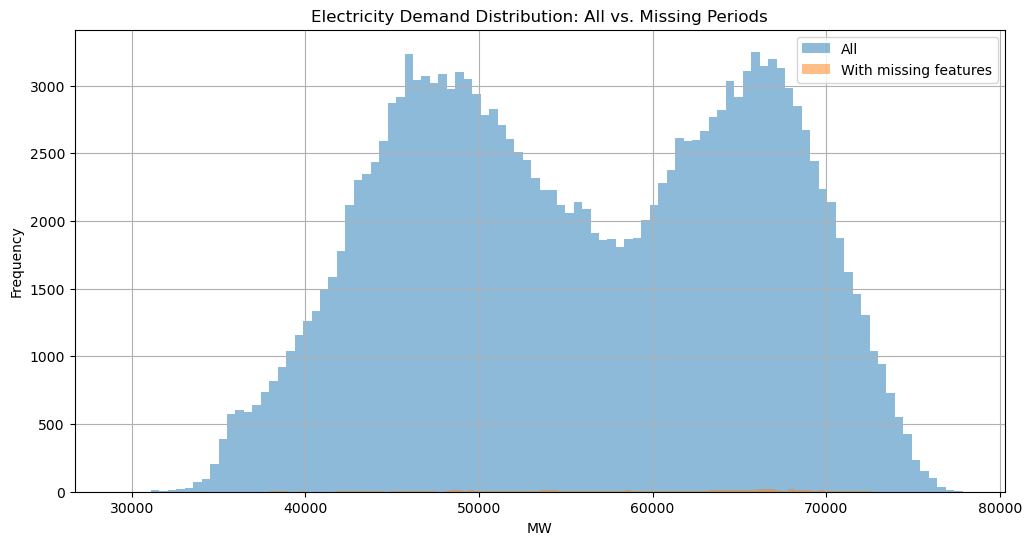

In [6]:
# Analyze Target Variable Behavior During Missing Periods

# Identify rows with any missing value
missing_any = merged_df[merged_df.isna().any(axis=1)]

# Compare distribution of the target during missing vs non-missing periods
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
merged_df["DE_load_actual_entsoe_transparency"].hist(alpha=0.5, label="All", bins=100)
missing_any["DE_load_actual_entsoe_transparency"].hist(alpha=0.5, label="With missing features", bins=100)
plt.title("Electricity Demand Distribution: All vs. Missing Periods")
plt.xlabel("MW")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Confirms that missing data periods occur fairly uniformly across the full range of demand, with no strong bias toward low or high consumption. That means you’re unlikely to introduce major distortions when imputing missing values for features, as your target distribution remains stable.

In [7]:
# Create is_daylight column

merged_df["is_daylight"] = merged_df["hour"].between(6, 20).astype(int)

Some analysis on imputation strategy:

Cannot just drop columns - due to time-series structure, temporal continuity and regular time steps matter. Preserving the time index matters for lags and training.

Ffill is a safe but not very intelligent method - it will flatten the curve of cyclical daily patterns.

(group-wise) interpolation could be a smarter technique.

Model-based imputation is possible with TFTs. Overkill for now, but keep a version of the merged dataset WITH missing values, which might be useful later.

In [91]:
# Save a backup before imputation
merged_df.to_csv("../data/processed/merged_dataset_pre_imputation.csv", index=False)


/var/folders/yz/m7lkwlgn4p38457jgz6z55b40000gn/T/ipykernel_12177/710879647.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


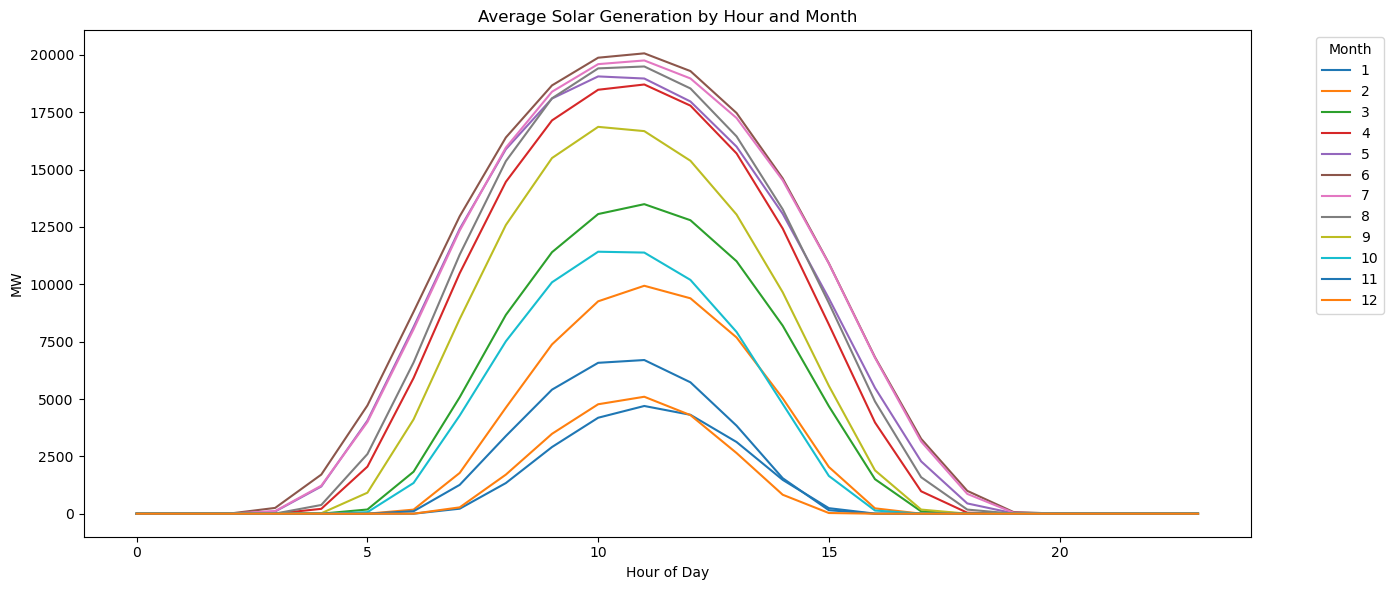

In [8]:
# Create a 'month' column (you already have 'hour')
merged_df["month"] = merged_df["utc_timestamp"].dt.month

# Check monthly hourly patterns for solar generation
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=merged_df,
    x="hour",
    y="DE_solar_generation_actual",
    hue="month",
    palette="tab10",
    estimator="mean",
    ci=None
)
plt.title("Average Solar Generation by Hour and Month")
plt.ylabel("MW")
plt.xlabel("Hour of Day")
plt.legend(title="Month", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Helps confirm the seasonal + daily solar pattern, which we’ll use for imputation.

In [9]:
# Build average solar generation values by hour and month
solar_pattern = merged_df.groupby(["month", "hour"])["DE_solar_generation_actual"].mean()

# Define a function to fill missing solar generation values using the pattern
def fill_with_solar_pattern(row):
    if pd.isna(row["DE_solar_generation_actual"]):
        return solar_pattern.loc[(row["month"], row["hour"])]
    else:
        return row["DE_solar_generation_actual"]

# Apply to the solar generation column
merged_df["DE_solar_generation_actual"] = merged_df.apply(fill_with_solar_pattern, axis=1)


In [10]:
# Select other generation columns that benefit from smoother gaps being filled
generation_cols_interpolate = [
    "DE_wind_generation_actual",
    "DE_wind_offshore_generation_actual",
    "DE_wind_onshore_generation_actual"
]

# Time interpolation (assumes utc_timestamp is datetime and sorted)
merged_df.set_index("utc_timestamp", inplace=True)
merged_df[generation_cols_interpolate] = merged_df[generation_cols_interpolate].interpolate(method='time')

# Reset index for further operations
merged_df.reset_index(inplace=True)


In [11]:
# Fallback in case any NaNs remain at beginning or end of time series
merged_df[generation_cols_interpolate] = merged_df[generation_cols_interpolate].fillna(method="ffill").fillna(method="bfill")


/var/folders/yz/m7lkwlgn4p38457jgz6z55b40000gn/T/ipykernel_12177/143081604.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[generation_cols_interpolate] = merged_df[generation_cols_interpolate].fillna(method="ffill").fillna(method="bfill")


✔ Saved original dataset for model-based or radiation-aware imputation later
✔ Used pattern-based interpolation (hour + month) for solar — respects seasonality & daily cycles
✔ Used time-based interpolation for wind — smooth enough, often less sharply cyclical
✔ Used forward/backward fill for edge NaNs — avoids gaps for time-series models
✔ Deferred advanced methods (radiation-scaling, XGBoost/TFT imputers) to feature engineering stage

In [12]:
# Summarize missing values per column
missing_summary = merged_df.isna().sum()
print(missing_summary[missing_summary > 0])


DE_load_forecast_entsoe_transparency    102
DE_solar_profile                        384
DE_wind_profile                         298
DE_wind_offshore_profile                298
DE_wind_onshore_profile                 288
dtype: int64


In [13]:
# Check for duplicate or missing times
print(merged_df["utc_timestamp"].diff().value_counts())


utc_timestamp
0 days 00:15:00    175166
Name: count, dtype: int64


Suggested strategies for remaining missingness:

For SARIMA (which likes simple, clean features):
- Drop the profiles unless they clearly add something.


For TFT (which can use many features and missingness indicators):
- Keep profiles, impute or flag missing values.

## 3: Trend Analysis

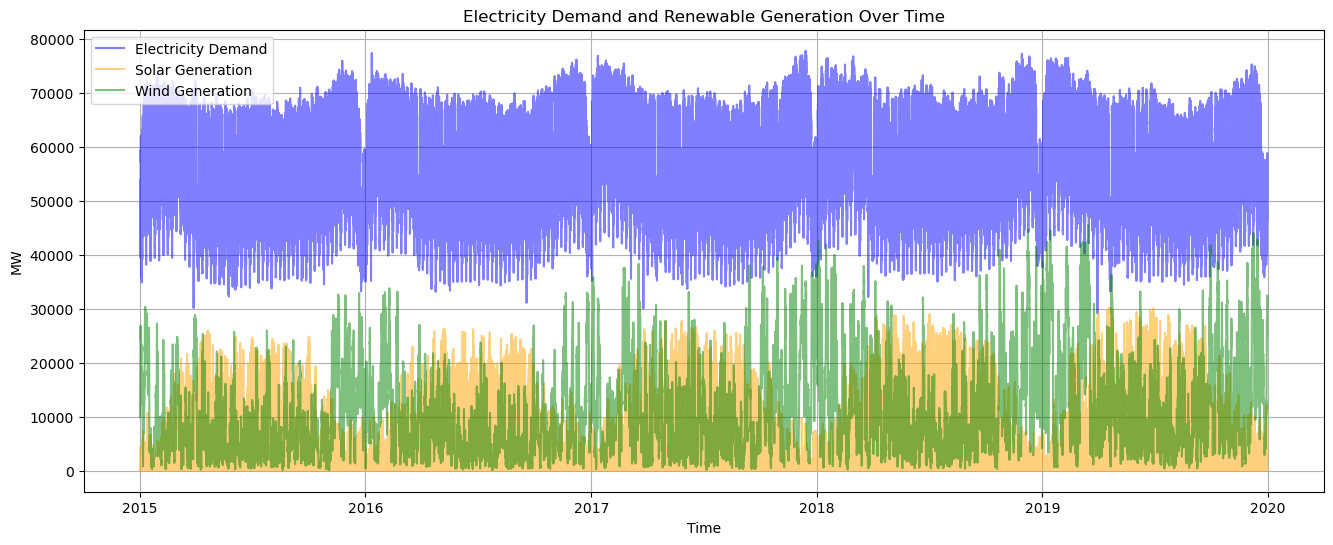

In [ ]:
# Plotting demand and renewables over time

plt.figure(figsize=(16, 6))
plt.plot(merged_df["utc_timestamp"], merged_df["DE_load_actual_entsoe_transparency"], label="Electricity Demand", color="blue", alpha=0.5)
plt.plot(merged_df["utc_timestamp"], merged_df["DE_solar_generation_actual"], label="Solar Generation", color="orange", alpha=0.5)
plt.plot(merged_df["utc_timestamp"], merged_df["DE_wind_generation_actual"], label="Wind Generation", color="green", alpha=0.5)

plt.xlabel("Time")
plt.ylabel("MW")
plt.title("Electricity Demand and Renewable Generation Over Time")
plt.legend()
plt.grid() # what does this do? 
plt.show()

- Electricity demand is stable with seasonable dips (winter/summer - why does electricity demand dip so much in winter??)
- Solar generation has a strong seasonal wave (summer highs, winter lows)
- Wind generation is more noisy but generally stronger in winter

Therefore: Seasonality is visible and strong - how can this affect feature engineering strategies??

❓ 1. Why does electricity demand dip so much in winter?
Actually, electricity demand tends to rise in winter in most countries because of:

Heating needs

Shorter days (more lighting required)

BUT:
In Germany and other parts of Europe:

Gas and district heating are the primary sources for heating — not electricity.

Some industries (like manufacturing) slow down in winter holidays (December shutdowns).

✅ Therefore, industrial slowdown + non-electric heating cause overall lower electricity demand during some winter periods, especially around Christmas–New Year.

❓ 2. How does strong seasonality affect feature engineering strategies?

➡️ You can engineer features that help the model "see" seasonality, for example:

Month of year (month, cos(2π * month/12), etc.)

Day of week (weekday, cos(2π * weekday/7))

Hour of day (hour, cyclically encoded)

Why?
Models like SARIMA or TFT are much better when you give them explicit seasonal signals.

✅ In short: add time-based features that express month, day of week, hour, maybe even holiday flags!



<Figure size 1400x800 with 0 Axes>

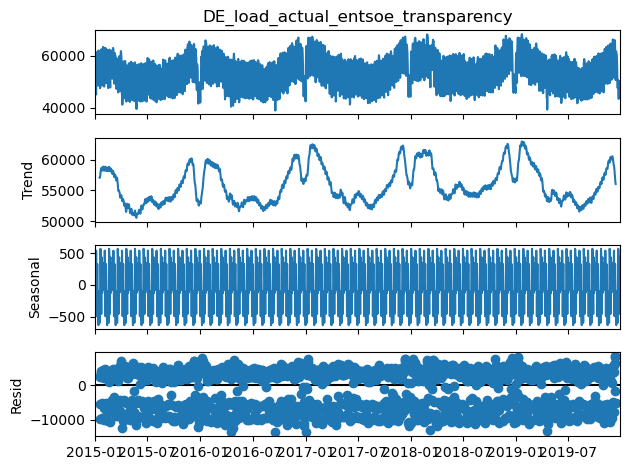

In [21]:
# Seasonal Decomposition Code:

from statsmodels.tsa.seasonal import seasonal_decompose

# Set the index to the timestamp column
df_decomp = merged_df.set_index("utc_timestamp")

# Resample to daily average (smoother decomposition)
df_decomp_daily = df_decomp['DE_load_actual_entsoe_transparency'].resample('D').mean()

# Decompose
decomposition = seasonal_decompose(df_decomp_daily, model='additive', period=30)

# Plot the decomposition make the plot bigger so that space issues are resolved and text is readable using decomposition.plot()
# Set the figure size
plt.figure(figsize=(14, 8))
# Plot the decomposition
decomposition.plot()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

- Demand generally decreases slightly over years (possibly energy efficiency and milder winter - possibly geopolitical?)
- Big drops (holidays or special events 2016 NYE, 2018 Christmas) [outliers? how to keep these in mind?]
- Seasonality repeats tightly, consistent daily or weekly seasonal patterns (good for modeling)
- Residual - no huge systematic errors (small random noise)

Conclusion: can model this with seasonality and a trend feature (weather and renewables as exogenous)
(What does this mean for feature engineering, specifically?)

❓ 1. Why does electricity demand dip so much in winter?
Actually, electricity demand tends to rise in winter in most countries because of:

Heating needs

Shorter days (more lighting required)

BUT:
In Germany and other parts of Europe:

Gas and district heating are the primary sources for heating — not electricity.

Some industries (like manufacturing) slow down in winter holidays (December shutdowns).

✅ Therefore, industrial slowdown + non-electric heating cause overall lower electricity demand during some winter periods, especially around Christmas–New Year.

❓ 3. Big drops (holidays or special events) → [Outliers? How to keep these in mind?]
Yes — big sudden drops (like NYE, Christmas) are outliers.

Two strategies:

Option 1 (simple): Accept them as rare events — models like TFT are robust to these.

Option 2 (smart):

Add a "holiday flag" feature (0 = normal day, 1 = holiday).

You can create it manually or use a package like workalendar for German holidays.

✅ For SARIMA: Outliers may make residuals fatter (higher variance) but small impact unless you have lots of them.

✅ For TFT: Holiday flag helps the model predict "weird days" better.

❓ 4. What does "model this with seasonality and a trend feature" mean for feature engineering, specifically?
Seasonality Features to add:

Hour of Day (0–23) and/or encoded as sine/cosine

Day of Week (0–6) and/or encoded as sine/cosine

Month of Year (1–12) and/or encoded as sine/cosine

Trend Features to add:

Time index: A continuously increasing variable (e.g., number of days since start).

Maybe a "year" feature (2015, 2016, etc.) if you see structural change.

External (exogenous) Features:

Temperature

Solar radiation

Wind speed

Actual renewable generation (wind/solar)

✅ Giving the model these explicit inputs lets it predict better instead of trying to learn time behavior blindly.



## 4: Correlation Analysis

Goal:
- How demand correlations with temp, radiation, wind, solar
- Which variables can be useful exogenous features (later)

In [24]:
print(merged_df.columns)

Index(['utc_timestamp', 'cet_cest_timestamp',
       'DE_load_actual_entsoe_transparency',
       'DE_load_forecast_entsoe_transparency', 'DE_solar_capacity',
       'DE_solar_generation_actual', 'DE_solar_profile', 'DE_wind_capacity',
       'DE_wind_generation_actual', 'DE_wind_profile',
       'DE_wind_offshore_capacity', 'DE_wind_offshore_generation_actual',
       'DE_wind_offshore_profile', 'DE_wind_onshore_capacity',
       'DE_wind_onshore_generation_actual', 'DE_wind_onshore_profile',
       'DE_temperature', 'DE_radiation_direct_horizontal',
       'DE_radiation_diffuse_horizontal', 'hour', 'is_daylight', 'month'],
      dtype='object')


Code above didn't work - think of a smart way to combine during feature engineering (or maybe not necessary)

In [35]:
corr_columns = [
    "DE_load_actual_entsoe_transparency",
    "DE_solar_generation_actual",
    "DE_wind_generation_actual",
    "DE_temperature"
]

# data types of corr_columns
print(merged_df[corr_columns].dtypes)

DE_load_actual_entsoe_transparency    float64
DE_solar_generation_actual            float64
DE_wind_generation_actual             float64
DE_temperature                        float64
dtype: object


In [37]:
print(merged_df[['DE_load_actual_entsoe_transparency',
                 'DE_solar_generation_actual',
                 'DE_wind_generation_actual',
                 'DE_temperature']].dropna().shape)


(175167, 4)


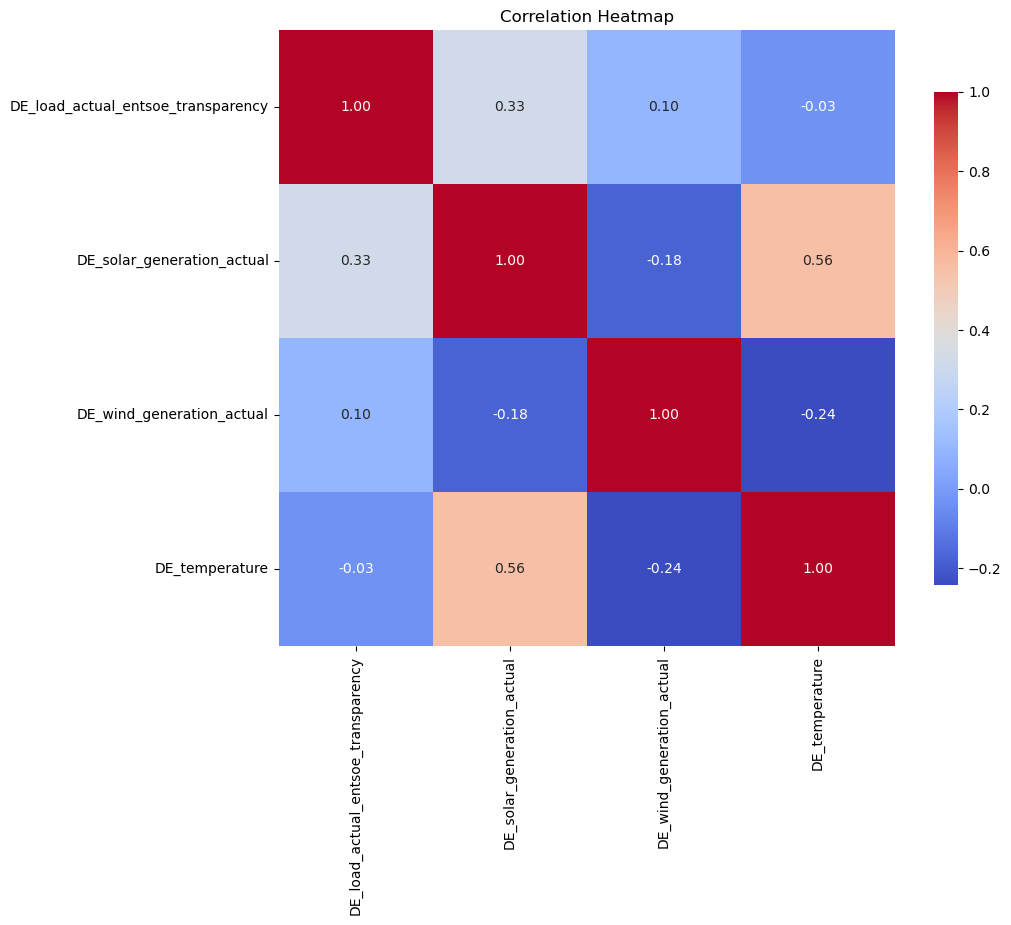

In [39]:
corr_columns = [
    "DE_load_actual_entsoe_transparency",
    "DE_solar_generation_actual",
    "DE_wind_generation_actual",
    "DE_temperature"
]

# Drop rows with missing values
corr_df = merged_df[corr_columns].dropna()

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap")
plt.show()

Demand is influenced by solar a bit (daytime patterns) but not strongly by weather alone

Wind is relatively independent

## 5: Distribution Plots

Are features skewed?

Seasonality checks

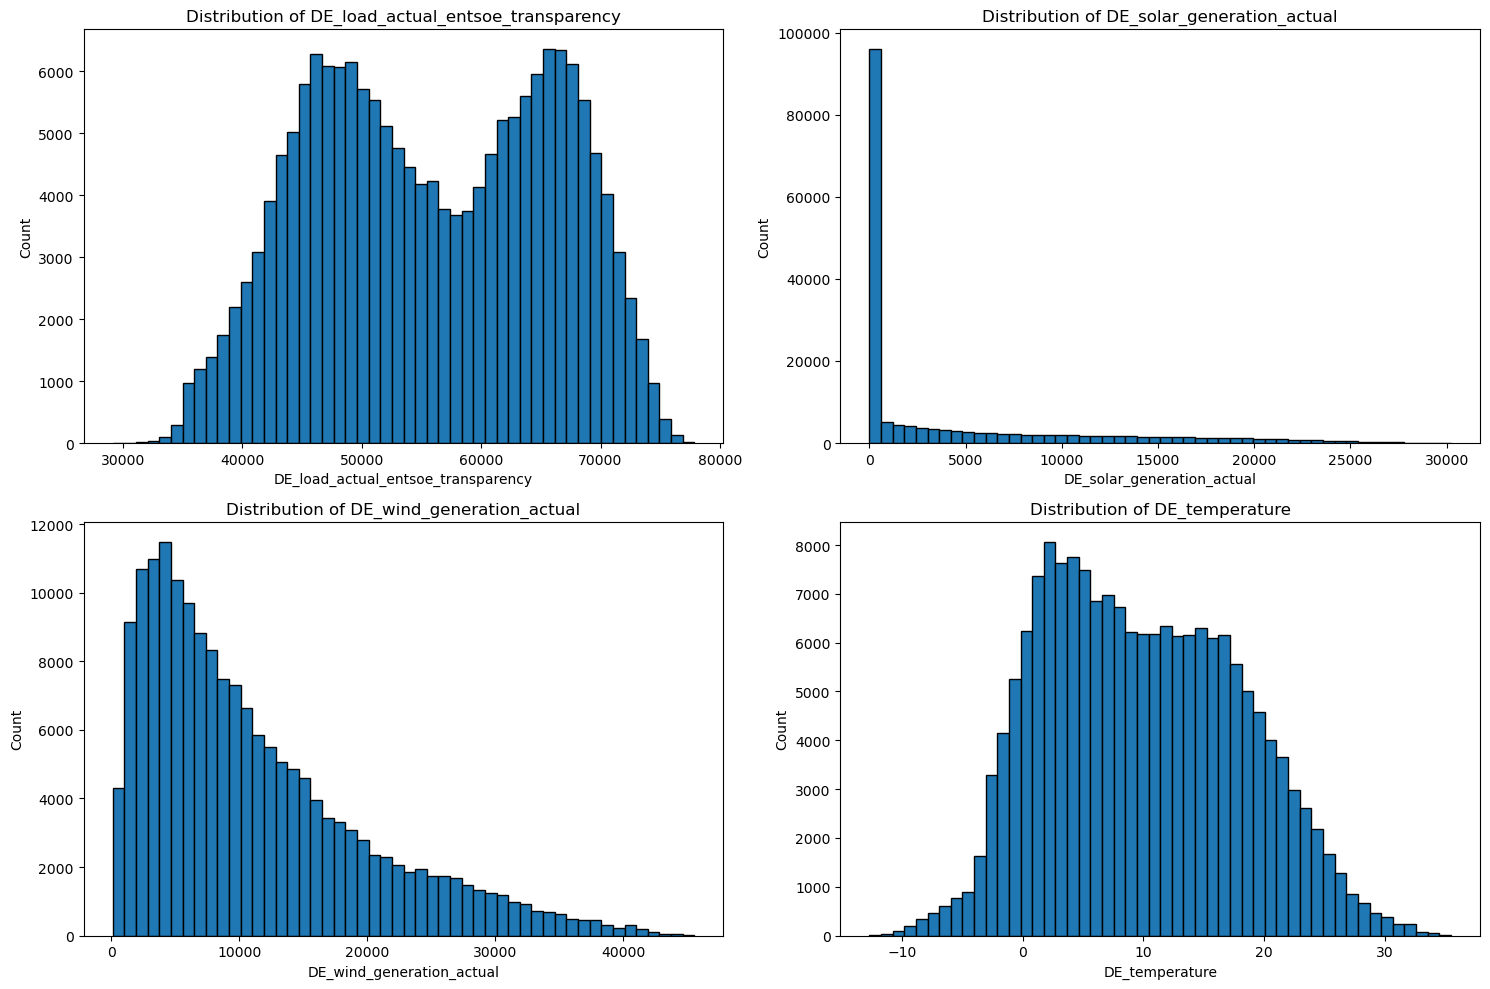

In [43]:
# Histogram for key variables

# Variables to plot
dist_columns = [
    'DE_load_actual_entsoe_transparency',
    'DE_solar_generation_actual',
    'DE_wind_generation_actual',
    'DE_temperature'
]

# Create histograms
plt.figure(figsize=(15,10))

for i, col in enumerate(dist_columns, 1):
    plt.subplot(2, 2, i)
    plt.hist(merged_df[col].dropna(), bins=50, edgecolor='k')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

Electricity demand:
- Bimodal shape: 2 clear peaks (winter/summer industrial behavior)
- Suggests seasonal effects
- Complex shape: benefit from clustering weekday/weekend & holiday flags

Solar generation:
- Strong right skew
- Most of the time low/zero, occasional srong solar days
- Treat carefully! Log-transform later

Wind generation:
- Right skew, smoother
- More variable, not as extreme as solar. Much more "baseline" production"

Temperature:
- Almost normal, slightly left skew
- Used raw or with small scaling

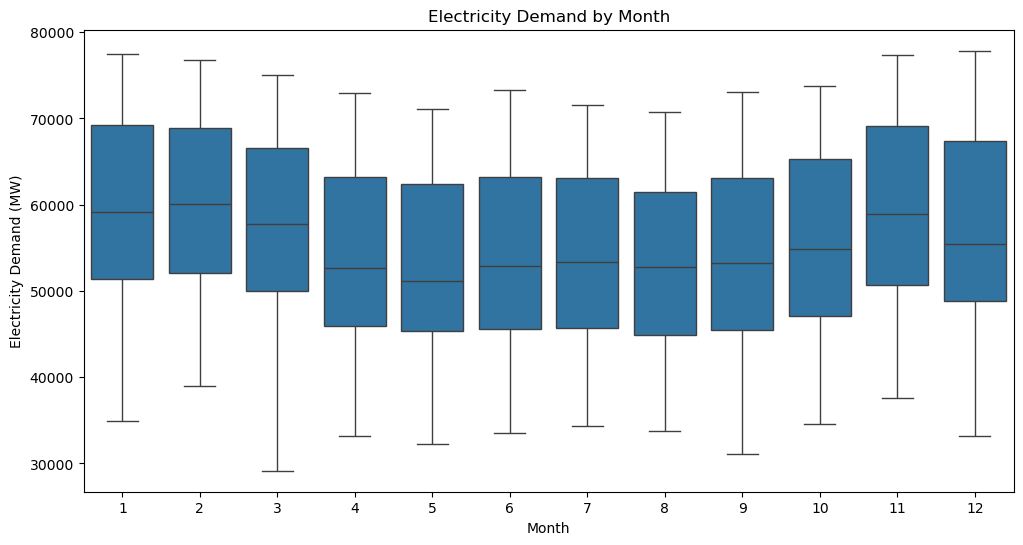

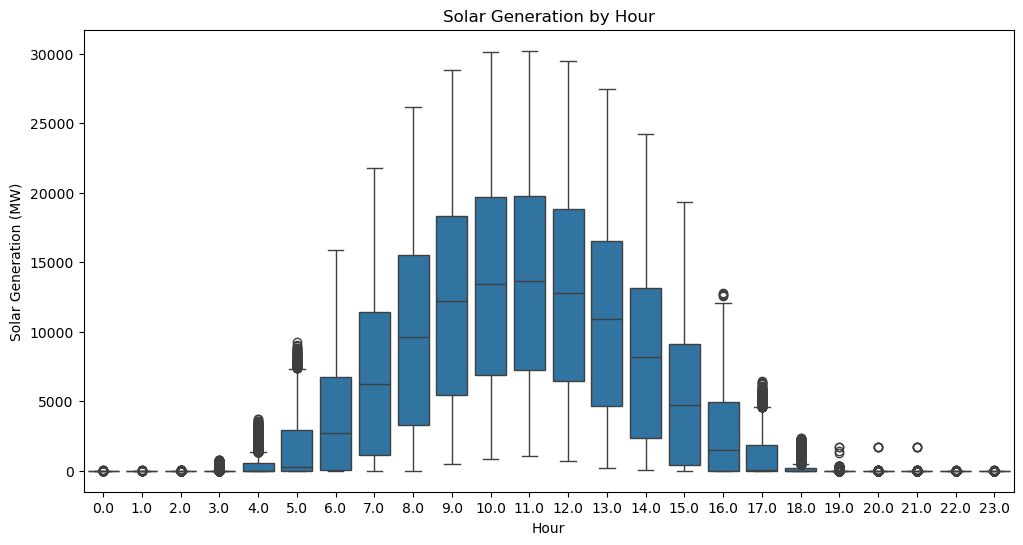

In [42]:
# Boxplot (Seasonality)

# Boxplot of Demand by Month
plt.figure(figsize=(12,6))
sns.boxplot(x='month', y='DE_load_actual_entsoe_transparency', data=merged_df)
plt.title('Electricity Demand by Month')
plt.xlabel('Month')
plt.ylabel('Electricity Demand (MW)')
plt.show()

# Boxplot of Solar Generation by Hour
plt.figure(figsize=(12,6))
sns.boxplot(x='hour', y='DE_solar_generation_actual', data=merged_df)
plt.title('Solar Generation by Hour')
plt.xlabel('Hour')
plt.ylabel('Solar Generation (MW)')
plt.show()

Electricity Demand by Month:
- Demand is the highest in winter (Dec-Feb) lowest in summer (July-August). The range is wide
- Good seasonal behavior
- Seasonality encoding is important!

Solar Generation by Hour
- Solar rises after 5-6 AM, peaks at noon, falls around 5-6PM
- Hour will be very predictive for solar generation

Month matters for demand, hour for solar generation, thus feature engineering should encode time!

In [44]:
# Save cleaned dataframe
merged_df.to_csv('../data/processed/merged_dataset_cleaned.csv', sep=';', index=False)